<h1>Análise de Sentimento em Tweets em Português</h1>

<h2>Contexto</h2>
<br/>

A base de dados tem tweets em português divididos em positivos, negativos e neutros para classificação de sentimentos.
<br/>

<br/>

Inicialmente, fazemos uma preparação dos dados, removendo ruídos, diminuindo a dimensionalidade dos tweets, padronização de itens lexicais e validação de símbolos para a classificação


<h4>Dados</h4>
<ul>
  <li>Training dataset: Train3Classes.csv</li>
  <li>Test dataset: Test3Classes.csv</li>
   <li>Custom Stopwords: stopwords-pt-br.txt</li>
</ul> 

<h4>Descrição das colunas</h4>
<ul>
  <li>id: identificador de string vindo do Twitter</li>
  <li>tweet_text: Texto completo do tweet</li>
  <li>tweet_date: Data de criação do tweet</li>
  <li>sentiment: Classificação de sentimento (positivo, negativo ou neutro)</li>
  <li>query_used: método de consulta para obtenção do tweet utilizado</li>
</ul> 

<h2>Conteúdo</h2>
<ul>
  <li>Carregando bibliotecas</li>
  <li>Divisão de colunas</li>
  <li>Carregando o dataset de treino</li>
  <li>Carregando o dataset de teste</li>
  <li>Preprocessamento do texto</li>
  <li>Análise exploratória</li>
  <li>Bag-of-Words</li>
  <li>Preparação do algoritmo e teste do modelo NB</li>
  <li>Predições individuais</li>
  <li>Avaliação do modelo</li>
  <li>Construindo pipeline MultinomialNB</li>
  <li>Construindo pipeline SGDClassifier(SVM)</li>
  <li>Ajuste de parâmetro usando grid search SGDClassifier</li>
  <li>Avaliando outros modelos</li>
  <li>Implementando Regressão Logística</li>
  <li>Implementing Random Forest</li>
  <li>Implementing Gradient Boosting Model</li>
  <li>Implementing Neural Networks (not implemented...)</li>
</ul>

<h2>Carregando bibliotecas</h2>

In [ ]:
import os
import pandas as pd
import numpy as np
import random
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
# from nltk.tokenize import sent_tokenize (Tokenization)
from nltk.probability import FreqDist
from nltk.metrics import ConfusionMatrix
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

<h2>Divisão de colunas</h2>

In [ ]:
# predictor
X_col = 'tweet_text'
# classifier
y_col = 'sentiment' 

<h2>Carregando o dataset de treino</h2>

<p>Cada tweet do conjunto de dados de treino já está classificado com um sentimento. O número 0 refere-se a um sentimento 
negativo, 1, neutro e 2 positivo.

<h4>Carregamento e preparo X_train, y_train</h4>

In [ ]:
train_ds = pd.read_csv('https://raw.githubusercontent.com/kodapdf/Sentiment-Analysis-Algorithms-Comparison/main/Train3Classes.csv', delimiter=';')
train_ds

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)
...,...,...,...,...,...
99995,1030468564715794432,Confira esta vaga na Senac-RS: Editor De Video...,Fri Aug 17 14:57:05 +0000 2018,2,#oportunidade
99996,1030468147353210881,Confira esta vaga na Grupo SABEMI: Assistente ...,Fri Aug 17 14:55:26 +0000 2018,2,#oportunidade
99997,1030467484766359552,Confira esta vaga na Groupe L’OCCITANE: Gerent...,Fri Aug 17 14:52:48 +0000 2018,2,#oportunidade
99998,1030466921702076416,"Está no ar o CandidatoWEB, seu novo portal de ...",Fri Aug 17 14:50:33 +0000 2018,2,#trabalho


In [ ]:
# Substitui a classificação por número pelo nome da classificação do sentimento
train_ds[y_col] = train_ds[y_col].map({0: 'Negative', 1: 'Positive', 2: 'Neutral'})
train_ds

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,Positive,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,Positive,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,Positive,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,Positive,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,Positive,:)
...,...,...,...,...,...
99995,1030468564715794432,Confira esta vaga na Senac-RS: Editor De Video...,Fri Aug 17 14:57:05 +0000 2018,Neutral,#oportunidade
99996,1030468147353210881,Confira esta vaga na Grupo SABEMI: Assistente ...,Fri Aug 17 14:55:26 +0000 2018,Neutral,#oportunidade
99997,1030467484766359552,Confira esta vaga na Groupe L’OCCITANE: Gerent...,Fri Aug 17 14:52:48 +0000 2018,Neutral,#oportunidade
99998,1030466921702076416,"Está no ar o CandidatoWEB, seu novo portal de ...",Fri Aug 17 14:50:33 +0000 2018,Neutral,#trabalho


In [ ]:
X_train = train_ds.loc[:, X_col].values #coluna de texto dos tweets
y_train = train_ds.loc[:, y_col].values #valor do sentimento aferido ao tweet

<h4>Exploratory Analysis</h4>

In [ ]:
# train_ds.head(5)
train_ds.sample(5)


,id,tweet_text,tweet_date,sentiment,query_used
13316,1047539144728223744,Deu ruim hein Camila Pitanga e cia... :) https...,Wed Oct 03 17:29:29 +0000 2018,Positive,:)
33103,1045331469449801728,Tão bom esperar 20 minutos por transporte :),Thu Sep 27 15:16:58 +0000 2018,Positive,:)
14213,1047498614371770368,@vendorepolho @Erro702 @AXEBR Passe bem também :),Wed Oct 03 14:48:25 +0000 2018,Positive,:)
20875,1046777371125272576,E eu que ñ tenho chaves de casa :))),Mon Oct 01 15:02:28 +0000 2018,Positive,:)
73172,1046911648936673280,Ampla defesa dos acusados justifica divulgação...,Mon Oct 01 23:56:02 +0000 2018,Neutral,folha


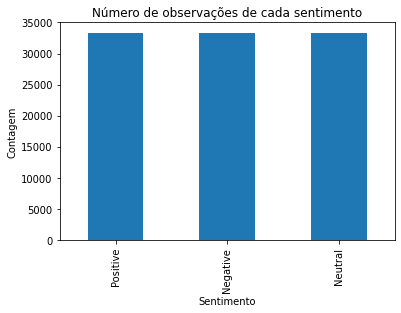

In [ ]:

series = train_ds['sentiment'].value_counts()

ax = series.plot(kind='bar', title='Número de observações de cada sentimento')
ax.set_xlabel('Sentimento')
ax.set_ylabel('Contagem')
plt.show()

Realizamos também a contagem por meio do caractere utilizado para realizar a consulta do tweet. Por exemplo, ":)" foi usado para buscar tweets positivos, ":(", negativos e assim por diante para outros temas, de modo a diversificar o dataset.

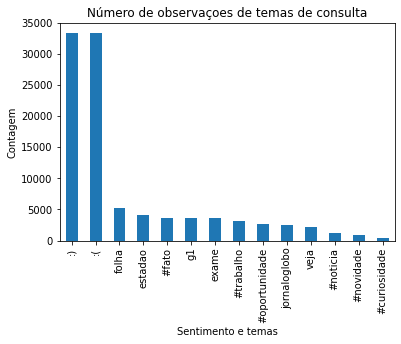

In [ ]:
#Contagem dos temas
series = train_ds['query_used'].value_counts()
ax = series.plot(kind='bar', title='Número de observaçoes de temas de consulta')
ax.set_xlabel('Sentimento e temas')
ax.set_ylabel('Contagem')
plt.show()

In [ ]:
# check data
for i in range(0, 5):
    print(y_train[i], ' => ', X_train[i])

Positive  =>  @Laranjito76 A pessoa certa para isso seria o vale e azevedo :)
Positive  =>  @behin_d_curtain Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)
Positive  =>  Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D
Positive  =>  aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :) https://t.co/pbIp7tRcSE
Positive  =>  Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :)) https://t.co/5c7wlXQyz9


<h2>Carregar conjunto de teste</h2>

<h4>Carregar e preparar X_test, y_test</h4>

In [ ]:
test_ds = pd.read_csv('https://raw.githubusercontent.com/kodapdf/Sentiment-Analysis-Algorithms-Comparison/main/Test3classes.csv', delimiter=';')
test_ds

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)
...,...,...,...,...,...
4994,1025115924570034177,STF prorroga inquérito contra Temer por propin...,Thu Aug 02 20:27:36 +0000 2018,2,exame
4995,1025116532358053888,O misterioso assassinato de três jornalistas r...,Thu Aug 02 20:30:01 +0000 2018,2,g1
4996,1025117394262519808,Homem morre atropelado por PM na saída do Túne...,Thu Aug 02 20:33:27 +0000 2018,2,jornaloglobo
4997,1025117768860033025,Ibope: TV é principal meio usado por eleitor p...,Thu Aug 02 20:34:56 +0000 2018,2,exame


In [ ]:
# Atualizamos os classificadores de sentimento para uma variável nominal
test_ds[y_col] = test_ds[y_col].map({0: 'Negative', 1: 'Positive', 2: 'Neutral'})
test_ds

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,Positive,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,Positive,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,Positive,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,Positive,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,Positive,:)
...,...,...,...,...,...
4994,1025115924570034177,STF prorroga inquérito contra Temer por propin...,Thu Aug 02 20:27:36 +0000 2018,Neutral,exame
4995,1025116532358053888,O misterioso assassinato de três jornalistas r...,Thu Aug 02 20:30:01 +0000 2018,Neutral,g1
4996,1025117394262519808,Homem morre atropelado por PM na saída do Túne...,Thu Aug 02 20:33:27 +0000 2018,Neutral,jornaloglobo
4997,1025117768860033025,Ibope: TV é principal meio usado por eleitor p...,Thu Aug 02 20:34:56 +0000 2018,Neutral,exame


In [ ]:
X_test = test_ds.loc[:, X_col].values
y_test = test_ds.loc[:, y_col].values

<h4>Análise exploratória do conjunto de teste</h4>

In [ ]:
# test_ds.head(5)
test_ds.sample(5)

,id,tweet_text,tweet_date,sentiment,query_used
2773,1030508774581252096,@whogisl real :((( ainda bem q nunca é tarde p...,Fri Aug 17 17:36:52 +0000 2018,Negative,:(
1703,1030495386568458242,@bchartsnet tadinho do meu amor :(,Fri Aug 17 16:43:40 +0000 2018,Negative,:(
93,1029538189655126017,ai to muito feliz que eu to percebendo cada va...,Wed Aug 15 01:20:06 +0000 2018,Positive,:)
4476,1024711356958822406,Gêmeas se lançam em lados opostos da política ...,Wed Aug 01 17:40:00 +0000 2018,Neutral,jornaloglobo
4378,1024520096449011712,'Tinder das eleições': aplicativo vai indicar ...,Wed Aug 01 05:00:00 +0000 2018,Neutral,jornaloglobo


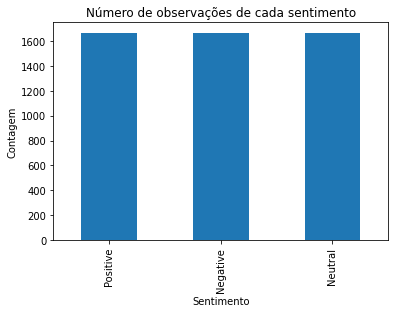

In [ ]:

series = test_ds['sentiment'].value_counts()
ax = series.plot(kind='bar', title='Número de observações de cada sentimento')
ax.set_xlabel('Sentimento')
ax.set_ylabel('Contagem')
plt.show()

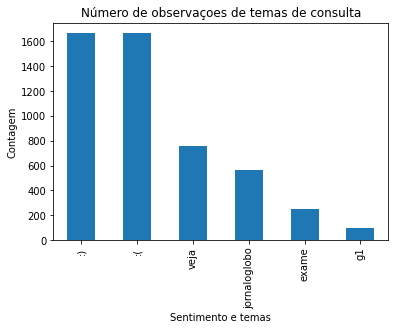

In [ ]:
series = test_ds['query_used'].value_counts()

ax = series.plot(kind='bar', title='Número de observaçoes de temas de consulta')
ax.set_xlabel('Sentimento e temas')
ax.set_ylabel('Contagem')
plt.show()

In [ ]:
# checagem
for i in range(0, 5):
    print(y_test[i], ' => ', X_test[i])

Positive  =>  @Gazo1a Nossa! Muito obrigada :)
Positive  =>  @BerzGamer vai pa puta que te pariu :)
Positive  =>  QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira no link ➔ https://t.co/jhh0Ttlpq3 | » Compartilhe! « Não encontrou a oferta ou cupom que procurava? Não se preocupe ;) criamos uma pagina com mais ofertas e cupons atualizada diariamente :) https://t.co/IgeeD0WmPf
Positive  =>  EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR DE BUTERA. :) #MMVAs #iHeartRadioMMVAs #FFSingleNoTears https://t.co/ghZMLqRFiV
Positive  =>  Estávamos em casa do Zé e eu estava a morrer de sono, chego a casa e fico sem sono :))))


<h2>Preprocessamento de texto</h2>

<h4>Planejamento</h4>
<ul>
  <li>Remoção de Ruído</li>
    <ul>
      <li>Remove urls do texto(http(s), www)</li>
      <li>Remove padrão regex (hashtags, notações)</li>
      <li>Preparar texto, substituir emots ":)) :) :D :(" por positive_emoticon ou negative_emoticon ou neutral_emoticon tags</li>
    </ul>
  <li>Tokenização do texto </li>
  <li>Padronização do objeto</li>
  <li>Remoção de stopwords (remoção de ruído e redução de dimensão)</li>
  <li>Normalização de itens lexicais</li>
    <ul>
      <li>Lematização - lemmatization (not implemented...)</li>
      <li>Derivação - stemming(dimensionality reduction)</li>
    </ul>
</ul> 

<h4>Remoção de ruído</h4>

Remove urls dos tweets (http(s), www)

In [ ]:
def _remove_url(data):
    ls = []
    words = ''
    regexp1 = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    regexp2 = re.compile('www?.(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    
    for line in data:
        urls = regexp1.findall(line)

        for u in urls:
            line = line.replace(u, ' ')

        urls = regexp2.findall(line)

        for u in urls:
            line = line.replace(u, ' ')
            
        ls.append(line)
    return ls

In [ ]:
X_train = _remove_url(X_train)
X_test = _remove_url(X_test)

Remove padrões regex  (hashtags, notações) - Regex representa uma expressão regular imutável 

In [ ]:
def _remove_regex(data, regex_pattern):
    ls = []
    words = ''
    
    for line in data:
        matches = re.finditer(regex_pattern, line)
        
        for m in matches: 
            line = re.sub(m.group().strip(), '', line)

        ls.append(line)

    return ls

In [ ]:
# hashtags
regex_pattern = '#[\w]*'
X_train = _remove_regex(X_train, regex_pattern)
X_test = _remove_regex(X_test, regex_pattern)

In [ ]:
# notaçoes
regex_pattern = '@[\w]*'
X_train = _remove_regex(X_train, regex_pattern)
X_test = _remove_regex(X_test, regex_pattern)

In [ ]:
# checagem de dados
for i in range(0, 5):
    print(X_train[i])

 A pessoa certa para isso seria o vale e azevedo :)
 Para mim, é precisamente o contrário :) Vem a chuva e vem a boa disposição :)
Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina   Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D
aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também :)  
Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele :))  


Preparação do texto, substituição de  emoticons ":)) :) :D :(" por positive_emoticon ou negative_emoticon ou neutral_emoticon

In [ ]:
def _replace_emoticons(data, emoticon_list):
    ls = []

    for line in data:
        for exp in emoticon_list:
            line = line.replace(exp, emoticon_list[exp])

        ls.append(line)

    return ls

In [ ]:
emoticon_list = {':))': 'positive_emoticon', ':)': 'positive_emoticon', ':D': 'positive_emoticon', ':(': 'negative_emoticon', ':((': 'negative_emoticon', '8)': 'neutral_emoticon'}

In [ ]:
X_train = _replace_emoticons(X_train, emoticon_list)
X_test = _replace_emoticons(X_test, emoticon_list)

In [ ]:
# checagem de dados
for i in range(0, 5):
    print(X_train[i])

 A pessoa certa para isso seria o vale e azevedo positive_emoticon
 Para mim, é precisamente o contrário positive_emoticon Vem a chuva e vem a boa disposição positive_emoticon
Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina   Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional positive_emoticon
aaaaaaaa amei tanto essas polaroids, nem sei expressar o quanto eu to apaixonada de vdd✨💖🎈🎉🎊 espero que outras pessoas consigam ganhar também positive_emoticon  
Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele positive_emoticon  


<h5 style="color:red;">Note: We can remove or replace with tags some noisy words or special characters like ✨💖🎈🎉🎊❤️, but we need to evaluate if they are important to express some sentiment</h5>

<h4>Tokenização do texto - </h4>

In [ ]:
#Separa os tweets pelas palavras, cada frase de um tweet transforma-se em uma string
def _tokenize_text(data):
    ls = []

    for line in data:
        tokens = wordpunct_tokenize(line)
        ls.append(tokens)

    return ls

In [ ]:
X_train_tokens = _tokenize_text(X_train)
X_test_tokens = _tokenize_text(X_test)

In [ ]:
# check data
for i in range(0, 5):
    print(X_train_tokens[i])

['A', 'pessoa', 'certa', 'para', 'isso', 'seria', 'o', 'vale', 'e', 'azevedo', 'positive_emoticon']
['Para', 'mim', ',', 'é', 'precisamente', 'o', 'contrário', 'positive_emoticon', 'Vem', 'a', 'chuva', 'e', 'vem', 'a', 'boa', 'disposição', 'positive_emoticon']
['Vou', 'fazer', 'um', 'video', 'hoje', '...', 'estou', 'pensando', 'em', 'falar', 'um', 'pouco', 'sobre', 'o', 'novo', 'meta', 'do', 'CSGO', 'e', 'sobre', 'a', 'pagina', 'Alguem', 'tem', 'uma', 'sugestao', '?', 'Queria', 'falar', 'sobre', 'algo', 'do', 'cenario', 'nacional', 'positive_emoticon']
['aaaaaaaa', 'amei', 'tanto', 'essas', 'polaroids', ',', 'nem', 'sei', 'expressar', 'o', 'quanto', 'eu', 'to', 'apaixonada', 'de', 'vdd', '✨💖🎈🎉🎊', 'espero', 'que', 'outras', 'pessoas', 'consigam', 'ganhar', 'também', 'positive_emoticon']
['Valoriza', 'o', 'coração', 'do', 'menininho', 'que', 'vc', 'tem', '.', 'Ele', 'é', 'diferente', '.', 'O', 'faça', 'sorrir', 'e', 'ter', 'certeza', 'disso', '❤️', '—', 'Eu', 'valorizo', 'todo', 'mundo',

<h4>Padronização de objetos</h4>

In [ ]:
def _apply_standardization(tokens, std_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() in std_list:
                word = std_list[word.lower()]
                
            new_tokens.append(word) 
            
        ls.append(new_tokens)

    return ls

In [ ]:
# lista de padronizacao
std_list = {'eh': 'é', 'vc': 'você', 'vcs': 'vocês','tb': 'também', 'tbm': 'também', 'obg': 'obrigado', 'gnt': 'gente', 'q': 'que', 'n': 'não', 'cmg': 'comigo', 'p': 'para', 'ta': 'está', 'to': 'estou', 'vdd': 'verdade'}

In [ ]:
# check data
print(X_train[4], X_train[35008])

Valoriza o coração do menininho que vc tem. Ele é diferente. O faça sorrir e ter certeza disso ❤️ — Eu valorizo todo mundo na minha vida, não vai ser diferente com ele positive_emoticon    Infelizmente isso acontece cmg tb.. negative_emoticon


In [ ]:
X_train_tokens = _apply_standardization(X_train_tokens, std_list)
X_test_tokens = _apply_standardization(X_test_tokens, std_list)

In [ ]:
# check data
print(X_train_tokens[4], X_train_tokens[35008])

['Valoriza', 'o', 'coração', 'do', 'menininho', 'que', 'você', 'tem', '.', 'Ele', 'é', 'diferente', '.', 'O', 'faça', 'sorrir', 'e', 'ter', 'certeza', 'disso', '❤️', '—', 'Eu', 'valorizo', 'todo', 'mundo', 'na', 'minha', 'vida', ',', 'não', 'vai', 'ser', 'diferente', 'com', 'ele', 'positive_emoticon'] ['Infelizmente', 'isso', 'acontece', 'comigo', 'também', '..', 'negative_emoticon']


In [ ]:
print(X_test_tokens[0:5])

[['Nossa', '!', 'Muito', 'obrigada', 'positive_emoticon'], ['vai', 'pa', 'puta', 'que', 'te', 'pariu', 'positive_emoticon'], ['QUER', 'MAIS', 'DESCONTOS', '?', '(', '14', '/', '0neutral_emoticon', '⭐⭐⭐⭐⭐', '🌐', 'Confira', 'no', 'link', '➔', '|', '»', 'Compartilhe', '!', '«', 'Não', 'encontrou', 'a', 'oferta', 'ou', 'cupom', 'que', 'procurava', '?', 'Não', 'se', 'preocupe', ';)', 'criamos', 'uma', 'pagina', 'com', 'mais', 'ofertas', 'e', 'cupons', 'atualizada', 'diariamente', 'positive_emoticon'], ['EU', 'VOU', 'PEGAR', 'vocês', ',', 'ME', 'AJUDEM', 'GALERA', ',', 'PELO', 'AMOR', 'DE', 'BUTERA', '.', 'positive_emoticon'], ['Estávamos', 'em', 'casa', 'do', 'Zé', 'e', 'eu', 'estava', 'a', 'morrer', 'de', 'sono', ',', 'chego', 'a', 'casa', 'e', 'fico', 'sem', 'sono', 'positive_emoticon', '))']]


<h4>Remoção de stopwords (remoção de ruído e redução de dimensão)</h4>

Stopwords são palavras comumente usadas na linguagem que não necessariamente adicionam significado a sentença, alguns exemplos são 

In [ ]:
def _remove_stopwords(tokens, stopword_list):
    ls = []

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            if word.lower() not in stopword_list:
                new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [ ]:
stopword_list = []

In [ ]:
# get nltk portuguese stopwords
nltk.download('stopwords')


nltk_stopwords = nltk.corpus.stopwords.words('portuguese')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# get custom stopwords from a file (pt-br). You can create your own database of stopwords on a text file, mongodb, so on...
df = pd.DataFrame(nltk_stopwords)
print(df.head(10))

     0
0   de
1    a
2    o
3  que
4    e
5    é
6   do
7   da
8   em
9   um


In [ ]:
# list of array
custom_stopwords = df.values.tolist()
# transform list of array to list
custom_stopwords = [s[0] for s in custom_stopwords]

In [ ]:
# You can also add stopwords manually instead of loading from the database. Generally, we add stopwords that belong to this context.
stopword_list.append('é')
stopword_list.append('vou')
stopword_list.append('que')
stopword_list.append('tão')
stopword_list.append('...')
stopword_list.append('«')
stopword_list.append('➔')
stopword_list.append('|')
stopword_list.append('»')
stopword_list.append('uai')
stopword_list.append("[")
stopword_list.append("]")
stopword_list.append("!")
stopword_list.append(":")
stopword_list.append(".")
stopword_list.append("?")
stopword_list.append("(")
stopword_list.append(")")
stopword_list.append(";")
stopword_list.append(",")
stopword_list.append("-")
stopword_list.append("'")


Além das stopwords, adicionamos na lista também alguns outros caracteres como pontuações ("-", "`", ","  ) e caracteres especiais ("$", "&" ) que não expressam sentimentos e portanto não são relevantes para tal análise




In [ ]:
# junta todas as stopwords
stopword_list.extend(nltk_stopwords)
#stopword_list.extend(custom_stopwords)

In [ ]:
# remove duplicatas  (lista unica)
stopword_list = list(set(stopword_list))

In [ ]:
X_train_tokens = _remove_stopwords(X_train_tokens, stopword_list)
X_test_tokens = _remove_stopwords(X_test_tokens, stopword_list)

In [ ]:
# check data
for i in range(0, 5):
    print(X_train_tokens[i])

['pessoa', 'certa', 'vale', 'azevedo', 'positive_emoticon']
['mim', 'precisamente', 'contrário', 'positive_emoticon', 'Vem', 'chuva', 'vem', 'boa', 'disposição', 'positive_emoticon']
['fazer', 'video', 'hoje', 'pensando', 'falar', 'pouco', 'sobre', 'novo', 'meta', 'CSGO', 'sobre', 'pagina', 'Alguem', 'sugestao', 'Queria', 'falar', 'sobre', 'algo', 'cenario', 'nacional', 'positive_emoticon']
['aaaaaaaa', 'amei', 'tanto', 'polaroids', 'sei', 'expressar', 'quanto', 'apaixonada', 'verdade', '✨💖🎈🎉🎊', 'espero', 'outras', 'pessoas', 'consigam', 'ganhar', 'positive_emoticon']
['Valoriza', 'coração', 'menininho', 'diferente', 'faça', 'sorrir', 'ter', 'certeza', 'disso', '❤️', '—', 'valorizo', 'todo', 'mundo', 'vida', 'vai', 'ser', 'diferente', 'positive_emoticon']


<h4>Normalização de itens lexicais</h4>

Stemming (dimensionality reduction)

In [ ]:
def _apply_stemmer(tokens):
    ls = []
    stemmer = nltk.stem.RSLPStemmer()

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            word = str(stemmer.stem(word))
            new_tokens.append(word) 
            
        ls.append(new_tokens)
        
    return ls

In [ ]:
nltk.download('rslp')

X_train_tokens = _apply_stemmer(X_train_tokens)
X_test_tokens = _apply_stemmer(X_test_tokens)

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [ ]:
# check data
for i in range(0, 5):
    print(X_train_tokens[i])

['pesso', 'cert', 'val', 'azeved', 'positive_emoticon']
['mim', 'precis', 'contr', 'positive_emoticon', 'vem', 'chuv', 'vem', 'boa', 'dispos', 'positive_emoticon']
['faz', 'vide', 'hoj', 'pens', 'fal', 'pouc', 'sobr', 'nov', 'met', 'csg', 'sobr', 'pagin', 'algu', 'sugesta', 'quer', 'fal', 'sobr', 'alg', 'cenari', 'nacion', 'positive_emoticon']
['aaaaaaa', 'ame', 'tant', 'polaroid', 'sei', 'express', 'quant', 'apaixon', 'verdad', '✨💖🎈🎉🎊', 'esper', 'outr', 'pesso', 'consig', 'ganh', 'positive_emoticon']
['valoriz', 'coraçã', 'menin', 'difer', 'faç', 'sorr', 'ter', 'cert', 'diss', '❤️', '—', 'valoriz', 'tod', 'mund', 'vid', 'vai', 'ser', 'difer', 'positive_emoticon']


<h2>Análise exploratória das palavras</h2>

<h4>Nuvem de palavras</h4>

In [ ]:
def _get_text_cloud(tokens):
    text = ''

    for tk_line in tokens:
        new_tokens = []
        
        for word in tk_line:
            text += word + ' '
        
    return text

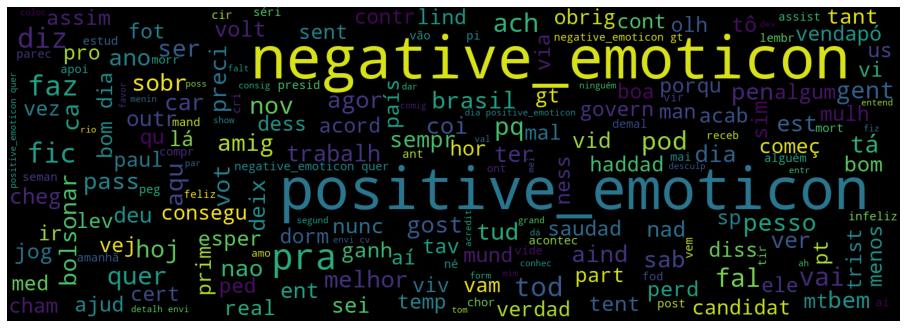

In [ ]:
# printa WordCloud do ocnjunto de treino
sample_train = random.sample(X_train_tokens, 10000)
text_cloud = _get_text_cloud(sample_train)

word_cloud = WordCloud(max_font_size = 100, width = 1520, height = 535)
word_cloud.generate(text_cloud)
plt.figure(figsize = (16, 9))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

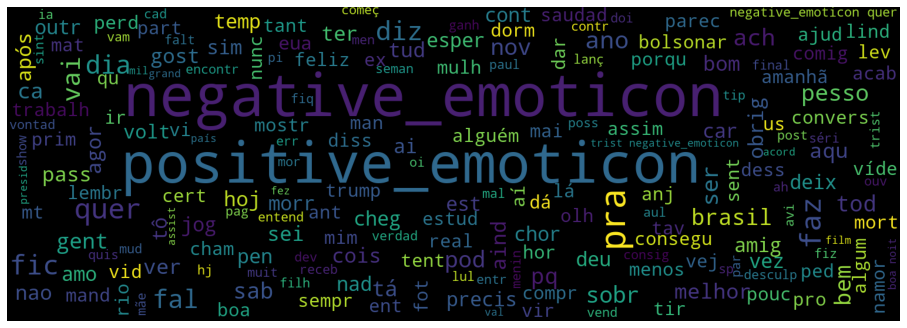

In [ ]:
# printa WordCloud do conjunto de teste
sample_test = random.sample(X_test_tokens, len(X_test_tokens))
text_cloud = _get_text_cloud(sample_test)

word_cloud = WordCloud(max_font_size = 100, width = 1520, height = 535)
word_cloud.generate(text_cloud)
plt.figure(figsize = (16, 9))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

<h4>Distribuição de frequência</h4>

In [ ]:
def _get_freq_dist_list(tokens):
    ls = []

    for tk_line in tokens:
        for word in tk_line:
            ls.append(word)

    return ls

In [ ]:
# dist. de frequencia do conjunto de treino
fd_list = _get_freq_dist_list(X_train_tokens)
fdist = FreqDist(fd_list)
print(fdist)

<FreqDist with 36914 samples and 869061 outcomes>


In [ ]:
# palavras mais comuns
most_common = fdist.most_common(25)
print(most_common)

[('negative_emoticon', 33232), ('positive_emoticon', 31038), ('pra', 7604), ('quer', 5631), ('dia', 5121), ('faz', 4503), ('vai', 4228), ('"', 3926), ('diz', 3853), ('tod', 3809), ('fic', 3689), ('ser', 3586), ('bolsonar', 3442), ('pod', 3398), ('&', 3249), ('fal', 3207), ('bem', 3153), ('ter', 2854), ('gt', 2832), ('bom', 2803), ('vot', 2792), ('ach', 2664), ('tá', 2619), ('tud', 2573), ('gent', 2517)]


In [ ]:
# palavras que menos apareceram
most_uncommon = fdist.hapaxes()
print(most_uncommon[0:30])

['sugesta', '✨💖🎈🎉🎊', 'ksoaksosk', 'centope', 'carril', 'fotogên', 'monlevad', 'feriad', ':’’)', 'naisuuu', 'eheheheheheh', 'apalp', 'paragraf', 'taxímetr', 'biray', 'ezîz', 'silavên', 'bikim', 'yasmyn', 'cabelooo', 'hextec', 'gontij', 'podiaa', 'piorrr', 'ngb', 'tác', 'armad', 'goe', 'dechav', 'αmig']


In [ ]:
# palavra que mais apareceu
fdist.max()

'negative_emoticon'

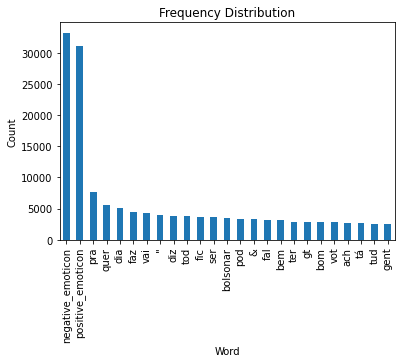

In [ ]:
# contagem das palavras mais comuns
series = pd.Series(data=[v for k, v in most_common], index=[k for k, v in most_common], name='')
ax = series.plot(kind='bar', title='Frequency Distribution')
ax.set_xlabel('Word')
ax.set_ylabel('Count')
plt.show()

Checando quantas vezes a palavra "brasil" aparece

In [ ]:
# numero de vezes
fdist.get('brasil')

2453

In [ ]:
# Freq = Numero de ocorrencias / total de palavras
fdist.freq('brasil') # 2453 / 984823

0.0028225866768845915

<h2>Bag-of-Words</h2>
O modelo saco de palavras ("bag of words") é um modelo simples de classificação de palavras, que consiste em quantificar quantas vezes uma determinada palavra aparece no texto.

<h4>Preparação do dataset</h4>
Primeiro precisamos desfazer a tokenização do texto

In [ ]:
def _untokenize_text(tokens):
    ls = []

    for tk_line in tokens:
        new_line = ''
        
        for word in tk_line:
            new_line += word + ' '
            
        ls.append(new_line)
        
    return ls

In [ ]:
X_train = _untokenize_text(X_train_tokens)
X_test = _untokenize_text(X_test_tokens)

In [ ]:
# check data
for i in range(0, 5):
    print(X_train[i])

pesso cert val azeved positive_emoticon 
mim precis contr positive_emoticon vem chuv vem boa dispos positive_emoticon 
faz vide hoj pens fal pouc sobr nov met csg sobr pagin algu sugesta quer fal sobr alg cenari nacion positive_emoticon 
aaaaaaa ame tant polaroid sei express quant apaixon verdad ✨💖🎈🎉🎊 esper outr pesso consig ganh positive_emoticon 
valoriz coraçã menin difer faç sorr ter cert diss ❤️ — valoriz tod mund vid vai ser difer positive_emoticon 


<h4>Extração de características do texto</h4>
Primeiro criamos um objeto contendo cada palavra do texto e o número de vezes em que ela ocorre.

<br/>
 

In [ ]:
# criar objeto vetor
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)

In [ ]:
print(X_train_vect.shape)

(100000, 33647)


In [ ]:
print(vectorizer.vocabulary_.get(u'pedro'))

None


Que pena!

In [ ]:
print(vectorizer.vocabulary_.get(u'brasil'))

6993


<h4>TF-IDF: Term Frequency - Inverse Document Frequency</h4>




TFIDF é uma medida estatística que busca identificar a importância de uma palavra no texto em relação ao conjunto total de dados. A métrica é obtida pelo produto entre a frequência de uma palavra em um documento - neste caso Tweet - e o inverso da frequência da mesma palavra em todo o dataset - conjunto de treino.

Usamos o método transform() para transformar a matriz de ocorrência em uma representação TF-IDF

In [ ]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vect)

In [ ]:
print(X_train_tfidf.shape)

(100000, 33647)


<h2>Preparo do algoritmo e teste do modelo</h2>

<h4>Treinando um classificador - MultinomialNB</h4>

In [ ]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

<h2>Predições</h2>

<h4>Predições individuais</h4>

Testamos o modelo em alguns tweets individuaius

In [ ]:
new_corpus = [
        '@acme A alegria está na luta, na tentativa, no sofrimento envolvido e não na vitória propriamente dita!', 
        'A alegria evita mil males e prolonga a vida.',
        'não se deve maltratar os idosos, eles possuem muita sabedoria!',
        '#filmedevampiro tome muito cuidado com o dracula... :( www.filmedevampiro.com.br',
        "O FLAMENGO É CAMPEÃO DA COPA CHEIRINHO 2021 PARABÉNS FLAMENGO!",
        "Assim de saúde vendo o Flamengo perder pro Palmeiras.. vai tomar no cu odeio o palmeiras vai se foder",
        "elas nao cantam nada vai se foder nao inventam uma letra nao dao um grito direito nao tem VONTADE nao tem nd não merecem show nao mereceeeeem vsf meud eus que raiva poreaa jdudiakaiwhrjajqja a a ajdje",
        "O mal é ficar se justificando pra pessoas que não consomem seu conteúdo e que não vivem a realidade que eles defendem na internet. O trabalhador não tá te perturbando na net não, bonner. Só faz o que é melhor pra tua realidade e arca com isso. A vida é assim. Só cabe a você isso."
        ]

<h4>Preprocessamento de novas observações</h4>

In [ ]:
X_new = new_corpus

In [ ]:
# Remove urls do texto (http(s), www)
X_new = _remove_url(X_new)

In [ ]:
# Remove hashtags
regex_pattern = '#[\w]*'
X_new = _remove_regex(X_new, regex_pattern)

In [ ]:
# Remove notações
regex_pattern = '@[\w]*'
X_new = _remove_regex(X_new, regex_pattern)

In [ ]:
# Substitui emoticons ":)) :) :D :(" por positive_emoticon ou negative_emoticon ou neutral_emoticon
X_new = _replace_emoticons(X_new, emoticon_list)

In [ ]:
# Tokenizacao do texto
X_new_tokens = _tokenize_text(X_new)

In [ ]:
# Padronizacao dos objetos
X_new_tokens = _apply_standardization(X_new_tokens, std_list)

In [ ]:
# remove stopwords
X_new_tokens = _remove_stopwords(X_new_tokens, stopword_list)

<h4>Normalização de itens lexicais</h4>

In [ ]:
# Stemming (redução de dimensão)
X_new_tokens = _apply_stemmer(X_new_tokens)

<h4>Bag-of-Words</h4>


In [ ]:
# Dataset preparation
# Untokenize text (transform tokenized text into string list)
X_new = _untokenize_text(X_new_tokens)

In [ ]:
# Text to Features
# Feature extraction from text 
# Method: bag of words
X_new_vect = vectorizer.transform(X_new)

In [ ]:
print(X_new_vect.shape)

(8, 33647)


In [ ]:
print(vectorizer.vocabulary_.get(u'idos'))
print(vectorizer.vocabulary_.get(u'alegr'))

17095
3929


In [ ]:
# TF-IDF: Term Frequency - Inverse Document Frequency
# use the transform(...) method to transform count-matrix to a tf-idf representation.
X_new_tfidf = tfidf_transformer.transform(X_new_vect)

In [ ]:
print(X_new_tfidf.shape)

(8, 33647)


<h4>Predições em novas observações</h4>

In [ ]:
standalone_predictions = model.predict(X_new_tfidf)

In [ ]:
for doc, prediction in zip(new_corpus, standalone_predictions):
    print('%r => %s' % (doc, prediction))

'@acme A alegria está na luta, na tentativa, no sofrimento envolvido e não na vitória propriamente dita!' => Positive
'A alegria evita mil males e prolonga a vida.' => Neutral
'não se deve maltratar os idosos, eles possuem muita sabedoria!' => Neutral
'#filmedevampiro tome muito cuidado com o dracula... :( www.filmedevampiro.com.br' => Negative
'O FLAMENGO É CAMPEÃO DA COPA CHEIRINHO 2021 PARABÉNS FLAMENGO!' => Neutral
'Assim de saúde vendo o Flamengo perder pro Palmeiras.. vai tomar no cu odeio o palmeiras vai se foder' => Positive
'elas nao cantam nada vai se foder nao inventam uma letra nao dao um grito direito nao tem VONTADE nao tem nd não merecem show nao mereceeeeem vsf meud eus que raiva poreaa jdudiakaiwhrjajqja a a ajdje' => Negative
'O mal é ficar se justificando pra pessoas que não consomem seu conteúdo e que não vivem a realidade que eles defendem na internet. O trabalhador não tá te perturbando na net não, bonner. Só faz o que é melhor pra tua realidade e arca com isso. A

<h2>Métrica de avaliação do modelo</h2>

Para avaliar os diferentes modelos implementados, usaremos a acurácia, que nada mais é do que a soma dos Verdadeiros Positivos e Negativos, dividida pelo total das classificações. Essas informações são apresentadas na matriz de confusão.

In [ ]:
def _get_accuracy(matrix):
    acc = 0
    n = 0
    total = 0
    
    for i in range(0, len(matrix)):
        for j in range(0, len(matrix)):
            if(i == j): 
                n += matrix[i,j]
            
            total += matrix[i,j]
            
    acc = n / total
    return acc

<h4>Bag-of-Words</h4>


In [ ]:
# Text to Features
# Feature extraction from text 
# Method: bag of words
X_test_vect = vectorizer.transform(X_test)
print(X_test_vect.shape)

(4999, 33647)


In [ ]:
# TF-IDF: Term Frequency - Inverse Document Frequency
# use the transform(...) method to transform count-matrix to a tf-idf representation.
X_test_tfidf = tfidf_transformer.transform(X_test_vect)
print(X_test_tfidf.shape)

(4999, 33647)


<h4>Predições no conjunto de teste</h4>

In [ ]:
predictions = model.predict(X_test_tfidf)

<h4>Análise dos resultados</h4>

In [ ]:
matrix = metrics.confusion_matrix(y_test, predictions)
print(matrix)

[[1541   18  107]
 [  21 1594   51]
 [ 122   48 1497]]


In [ ]:
print(model.classes_)

['Negative' 'Neutral' 'Positive']


In [ ]:
acc1 = np.mean(predictions == y_test)
acc2 = _get_accuracy(matrix)
print(acc1, acc2)

0.9265853170634126 0.9265853170634126


In [ ]:
for doc, prediction, y in zip(X_test[0:10], predictions[0:10], y_test[0:10]):
    print('%r => %s [%s]' % (doc, prediction, y))

'obrig positive_emoticon ' => Positive [Positive]
'vai pa put par positive_emoticon ' => Positive [Positive]
'qu descont 14 / 0neutral_emoticon ⭐⭐⭐⭐⭐ 🌐 conf link compartilh encontr ofert cupom procur preocup ;) cri pagin ofert cupom atual di positive_emoticon ' => Positive [Positive]
'peg ajud gal am but positive_emoticon ' => Positive [Positive]
'cas zé morr son cheg cas fic son positive_emoticon )) ' => Positive [Positive]
'precis positive_emoticon ' => Positive [Positive]
'acas ador beij abraç hahahahah bue fofii ahahah altur agor gost positive_emoticon ' => Positive [Positive]
'solt s so sempr positive_emoticon ' => Positive [Positive]
'lind cort kit mári coleç bia cravol cadastr sit esper pod ir adquir arras encomend afinal tem moment positive_emoticon ' => Positive [Positive]
'clar sim positive_emoticon ' => Positive [Positive]


In [ ]:
# analise da performance do modelo
print(metrics.classification_report(y_test, predictions, target_names=model.classes_))

              precision    recall  f1-score   support

    Negative       0.92      0.92      0.92      1666
     Neutral       0.96      0.96      0.96      1666
    Positive       0.90      0.90      0.90      1667

    accuracy                           0.93      4999
   macro avg       0.93      0.93      0.93      4999
weighted avg       0.93      0.93      0.93      4999



<h2>Pipeline MultinomialNB</h2>

Para facilitar o processo de vetorização  -> transformação -> classificação, usaremos uma classe Pipeline do scikit-learn que se comporta como uma classificador composto.

Procurando agilizar o pré-processamento dos dados realizados para a Bag of Words, implementamos um Pipeline que repetirá as funções CountVectorizer, TfidfTransformer e aplicará o modelo utilizado para a classificação, neste casso Multinomial Naive Bayes.

In [ ]:
model_MNB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])


Usamos os elementos 'vect', 'tfidf' e 'clf' (nomes arbitrários) para realizarmos uma "grid search" e encontrarmos os hiperparâmetros mais satisfatórios para o modelo de classificação. Podemos treinar o modelo facilmente agora:

In [ ]:
model_MNB.fit(X_train, y_train)
predictions_MNB = model_MNB.predict(X_test)

In [ ]:
matrix = metrics.confusion_matrix(y_test, predictions_MNB)
acc_NB = _get_accuracy(matrix)
print(acc_NB)

0.9265853170634126


<h2>Pipeline SGDClassifier, a linear support vector machine (SVM)</h2>

In [ ]:
model_SGD = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss = 'hinge', penalty = 'l2', alpha = 1e-3, random_state = 42, max_iter = 5, tol = None)),
])

In [ ]:
model_SGD.fit(X_train, y_train)
predictions_SGD = model_SGD.predict(X_test)

In [ ]:
matrix = metrics.confusion_matrix(y_test, predictions_SGD)
acc_antes = _get_accuracy(matrix)
print(acc_antes)

0.9585917183436687


<h2>Ajuste de parâmetro usando Grid Search SGDClassifier</h2>


Para encontrarmos os melhores hiperparâmetros recorremos a uma busca exaustiva usando GridSearch em um espaço de busca definido.

In [ ]:
#espaço de busca
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
}

In [ ]:
gs_model_SGD = GridSearchCV(model_SGD, parameters, cv = 5, n_jobs = -1)
gs_model_SGD = gs_model_SGD.fit(X_train, y_train)

In [ ]:
gs_predictions_SGD = gs_model_SGD.predict(['alegr lut tent sofr envolv não vit propri dit.'])
print(gs_predictions_SGD)

['Neutral']


In [ ]:
X_new

['alegr lut tent sofr envolv vitór propr dit ',
 'alegr evit mil mal prolong vid ',
 'dev maltrat idos possu muit sabed ',
 'tom cuid dracul negative_emoticon ',
 'flameng campeã cop che 2021 parabém flameng ',
 'assim saúd vend flameng perd pro palm .. vai tom cu odei palm vai fod ',
 'nao cant nad vai fod nao invent letr nao dao grit direit nao vontad nao nd merec show nao mereceeee vsf meud eu raiv porea jdudiakaiwhrjajqj ajdj ',
 'mal fic justific pra pesso consom conteúd viv real defend internet trabalh tá perturb net bonn faz melhor pra real arc vid assim cab ']

In [ ]:
gs_predictions_SGD = gs_model_SGD.predict(X_new)
print(gs_predictions_SGD)

['Neutral' 'Neutral' 'Neutral' 'Negative' 'Neutral' 'Neutral' 'Neutral'
 'Neutral']


In [ ]:
print(gs_model_SGD.best_score_)

0.96359


In [ ]:
print(gs_model_SGD.best_params_)

{'clf__alpha': 0.001, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}


In [ ]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_model_SGD.best_params_[param_name]))

clf__alpha: 0.001
tfidf__use_idf: False
vect__ngram_range: (1, 2)


Aplicando os hiperparâmetros ao conjunto de teste:

In [ ]:
parameters = {
    'vect__ngram_range': [(1, 2)],
    'tfidf__use_idf': [(False)],
    'clf__alpha': [(1e-3)],
}


In [ ]:
gs_model_SGD = GridSearchCV(model_SGD, parameters, cv = 5, n_jobs = -1)
gs_model_SGD = gs_model_SGD.fit(X_train, y_train)

In [ ]:
gs_predictions_SGD = gs_model_SGD.predict(X_test)
print(gs_predictions_SGD)

['Positive' 'Positive' 'Positive' ... 'Neutral' 'Neutral' 'Neutral']


In [ ]:
matrix = metrics.confusion_matrix(y_test, gs_predictions_SGD)
acc_dps = _get_accuracy(matrix)
print(acc_dps)

0.9591918383676735


In [ ]:
f'Melhora na acurácia do modelo {(acc_dps-acc_antes)/acc_antes}'

'Melhora na acurácia do modelo 0.000626043405676105'

In [ ]:
acc_SGD = acc_dps

Assim, filtrando os melhores hiperparâmetros, conseguimos aumentar nossa acurácia em 0.06%. É importante ressaltar que usamos um espaço de busca bastante reduzido em razão do poder de processamento limitado, se pudéssemos aumentar o número de combinações de hiperparâmetros testadas pelo GridSearch é provável que fóssemos capazes de encontrar modelos ainda mais precisos. 

<h2>Avaliando outros modelos</h2>
KNN Classifier
<br/>
Regressão Logística
<br/>
Support Vector Machine (SVM)
<br/>
Random Forest
<br/>
Gradient Boosting Model

Como não conseguimos uma melhora relevante por meio da GridSearch implementada anteriormente, não a aplicaremos aos outros modelos, já que o tempo de processamento é muito alto em relação a melhora da acurácia.

#KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_KN = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier()),
])

In [ ]:
model_KN.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [ ]:
predictions_KN = model_KN.predict(X_test)

In [ ]:
matrix = metrics.confusion_matrix(y_test, predictions_KN)
acc_KN = _get_accuracy(matrix)
print(acc_KN)

0.6095219043808762


#<h2> Regressão Logística</h2>

In [ ]:
model_LR = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(max_iter= 1000)),
])

In [ ]:

model_LR.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(max_iter=1000))])

In [ ]:
predictions_LR = model_LR.predict(X_test)

In [ ]:
matrix = metrics.confusion_matrix(y_test, predictions_LR)
acc_LR = _get_accuracy(matrix)
print(acc_LR)

0.9693938787757551


<h2> Random Forest </h2>

In [ ]:

model_RF = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier()),
])


In [ ]:

model_RF.fit(X_train, y_train)
predictions_RF = model_RF.predict(X_test)


In [ ]:

matrix = metrics.confusion_matrix(y_test, predictions_RF)
acc_RF = _get_accuracy(matrix)
print(acc_RF)


0.9745949189837968


<h2> Gradient Boosting Model</h2>

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


model_GB = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', GradientBoostingClassifier()),
])


In [ ]:

model_GB.fit(X_train, y_train)
predictions_GB = model_GB.predict(X_test)


In [ ]:

matrix = metrics.confusion_matrix(y_test, predictions_GB)
acc_GBM = _get_accuracy(matrix)
print(acc_GBM)


0.9605921184236847


#Comparação dos modelos

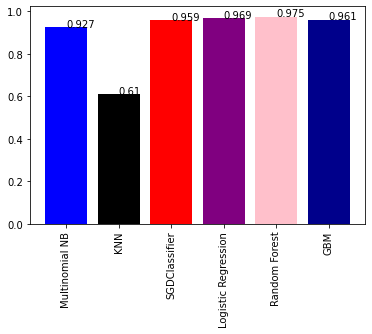

In [ ]:
acuracia = [acc_NB,acc_KN, acc_SGD, acc_LR, acc_RF, acc_GBM]
labels = ['Multinomial NB','KNN', 'SGDClassifier', 'Logistic Regression', 'Random Forest', 'GBM']
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

plt.bar(labels, acuracia, color = ['b', 'black', 'red', 'purple', 'pink', 'darkblue'])
addlabels(labels, np.round(acuracia,3))
plt.xticks(rotation=90)


plt.show()

Assim, o modelo Random Forest foi o que apresentou melhor performance no trabalho análise de sentimento.

É importante ressaltar também que decidimos não ajustar todos os modelos. O próprio Random Search, que nos ofereceu a maior acurácia não passou pelo processo, logo poderíamos ter ainda melhores resultados buscando pelos melhores hiperparâmetros.

#Bibliografia

**Understanding TFIDF** -> https://monkeylearn.com/blog/what-is-tf-idf/ \\
**A Gentle Introduction to the BagOfWords** -> https://machinelearningmastery.com/gentle-introduction-bag-words-model/ \\ 
**Machine Learning Basics with the K-Nearest Neighbors** -> https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761

**Multinominal Naive-Bayes Explained** -> https://www.upgrad.com/blog/multinomial-naive-bayes-explained/ \\

**Understanding Random Forest** -> https://towardsdatascience.com/understanding-random-forest-58381e0602d2

**Logistic Regression** -> https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc